# 1. Importing libraries

In [11]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Custom functions and classes
# -----------------------------------------------------------------------
from src.preprocess import preprocess
from src.eda import plot_relation_tv
from src.circuit_clustering_model.clustering import *


# 2. Data loading

We loaded the original circuits dataset and the dataset with feature engineering. Both datasets are clean and free of duplicates.

In [12]:
df = pd.read_csv('../data/output/circuits_complete.csv', index_col=0)

df.head()

,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,straight_length,gear_changes,n_slow_corners,n_medium_corners,n_fast_corners,n_gear1_corners,n_gear2_corners,n_gear3_corners,n_gear4_corners,n_gear5_corners,n_gear6_corners,n_gear7_corners,n_gear8_corners
hockenheimring,71.767,320.0,4568.748333,17,209.960540,229.888136,1663.919441,40.0,3,9,5,0,1,3,1,3,5,3,1
nurburgring,85.269,318.0,5112.340000,15,173.563856,216.201705,2043.790918,50.0,5,7,3,0,0,4,3,3,1,2,1
portimao,77.968,314.0,4637.664722,15,188.740533,214.136223,1800.793691,40.0,4,5,6,0,0,4,2,1,4,4,0
sochi,101.993,291.0,5789.306111,18,172.024977,204.520095,1284.998104,64.0,5,8,5,0,3,7,2,1,1,3,1
istanbul,82.868,321.0,5253.130833,14,176.854350,228.286957,3877.396258,39.0,3,8,3,0,3,1,4,1,0,2,1


In [13]:
df_featured = pd.read_csv('../data/output/featured_circuits_complete.csv', index_col=0)

df_featured.head()

,max_speed,distance,avg_corner_speed,avg_speed,short_gear_corners_prop,long_gear_corners_prop,slow_corners_prop,medium_corners_prop,fast_corners_prop,straight_prop,gear_changes_per_km,n_corners_per_km
hockenheimring,320.0,4568.748333,209.960540,229.888136,0.294118,0.705882,0.176471,0.529412,0.294118,0.364196,8.755133,3.720932
nurburgring,318.0,5112.340000,173.563856,216.201705,0.466667,0.466667,0.333333,0.466667,0.200000,0.399776,9.780257,2.934077
portimao,314.0,4637.664722,188.740533,214.136223,0.400000,0.600000,0.266667,0.333333,0.400000,0.388298,8.625031,3.234386
sochi,291.0,5789.306111,172.024977,204.520095,0.666667,0.333333,0.277778,0.444444,0.277778,0.221961,11.054865,3.109181
istanbul,321.0,5253.130833,176.854350,228.286957,0.571429,0.285714,0.214286,0.571429,0.214286,0.738111,7.424144,2.665077


# 3. Preprocessing  

To carry out the preprocessing, we need to evaluate the following aspects:  

* Remove the columns we do not want to consider:
    - In this case, we do not need to remove any columns since the datasets are already prepared for preprocessing.  

* Select the encoding methods for categorical variables:
    - We do not have categorical variables, so we do not need to perform `encoding`.  

* Select the scaling method: 
    - Since we have very few outliers in our datasets and there are no extremely high values, we will use a `MinMax` scaler.


In [14]:
encoding_methods = {}

scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling)
df_featured_encoded, df_featured_scaled = preprocess(df_featured, encoding_methods, scaling)

# 4. Clustering

## 4.1 K-means

In [18]:
df_featured_scaled.columns

Index(['max_speed', 'distance', 'avg_corner_speed', 'avg_speed',
       'short_gear_corners_prop', 'long_gear_corners_prop',
       'slow_corners_prop', 'medium_corners_prop', 'fast_corners_prop',
       'straight_prop', 'gear_changes_per_km', 'n_corners_per_km'],
      dtype='object')

Selección de características

In [19]:
df_kmeans = df_featured_scaled#[['laptime', 'max_speed', 'avg_speed', 'throttle_perc']]

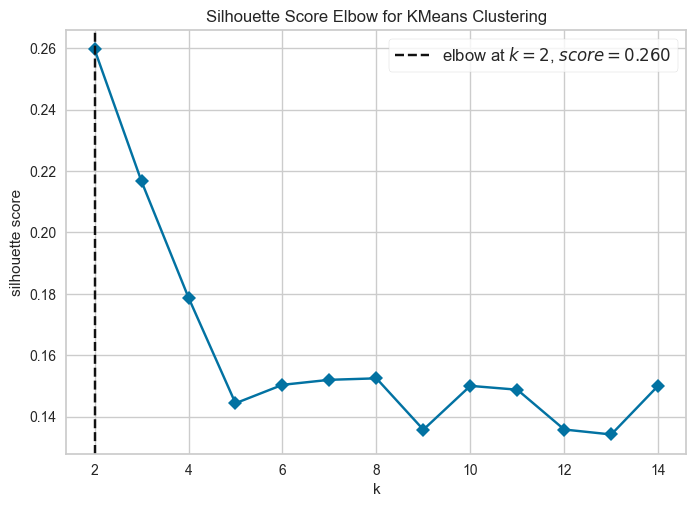

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [23]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df_kmeans)
visualizer.show()

In [24]:
model_kmeans = KMeans(n_clusters=2)

km_fit = model_kmeans.fit(df_kmeans)
labels = km_fit.labels_

In [25]:
clustering_metrics(df_kmeans, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.266313,1.328723,10
1,0.266313,1.328723,20


In [26]:
df_kmeans_result = df_kmeans.copy()

df_kmeans_result['cluster'] = km_fit.labels_

In [27]:
df_kmeans_result.sort_values(by='cluster')['cluster']

villeneuve        0
monaco            0
miami             0
shanghai          0
baku              0
hungaroring       0
marina_bay        0
sochi             0
nurburgring       0
rodriguez         0
americas          1
vegas             1
losail            1
yas_marina        1
monza             1
zandvoort         1
silverstone       1
hockenheimring    1
catalunya         1
spa               1
imola             1
suzuka            1
albert_park       1
jeddah            1
bahrain           1
ricard            1
istanbul          1
portimao          1
red_bull_ring     1
interlagos        1
Name: cluster, dtype: int32

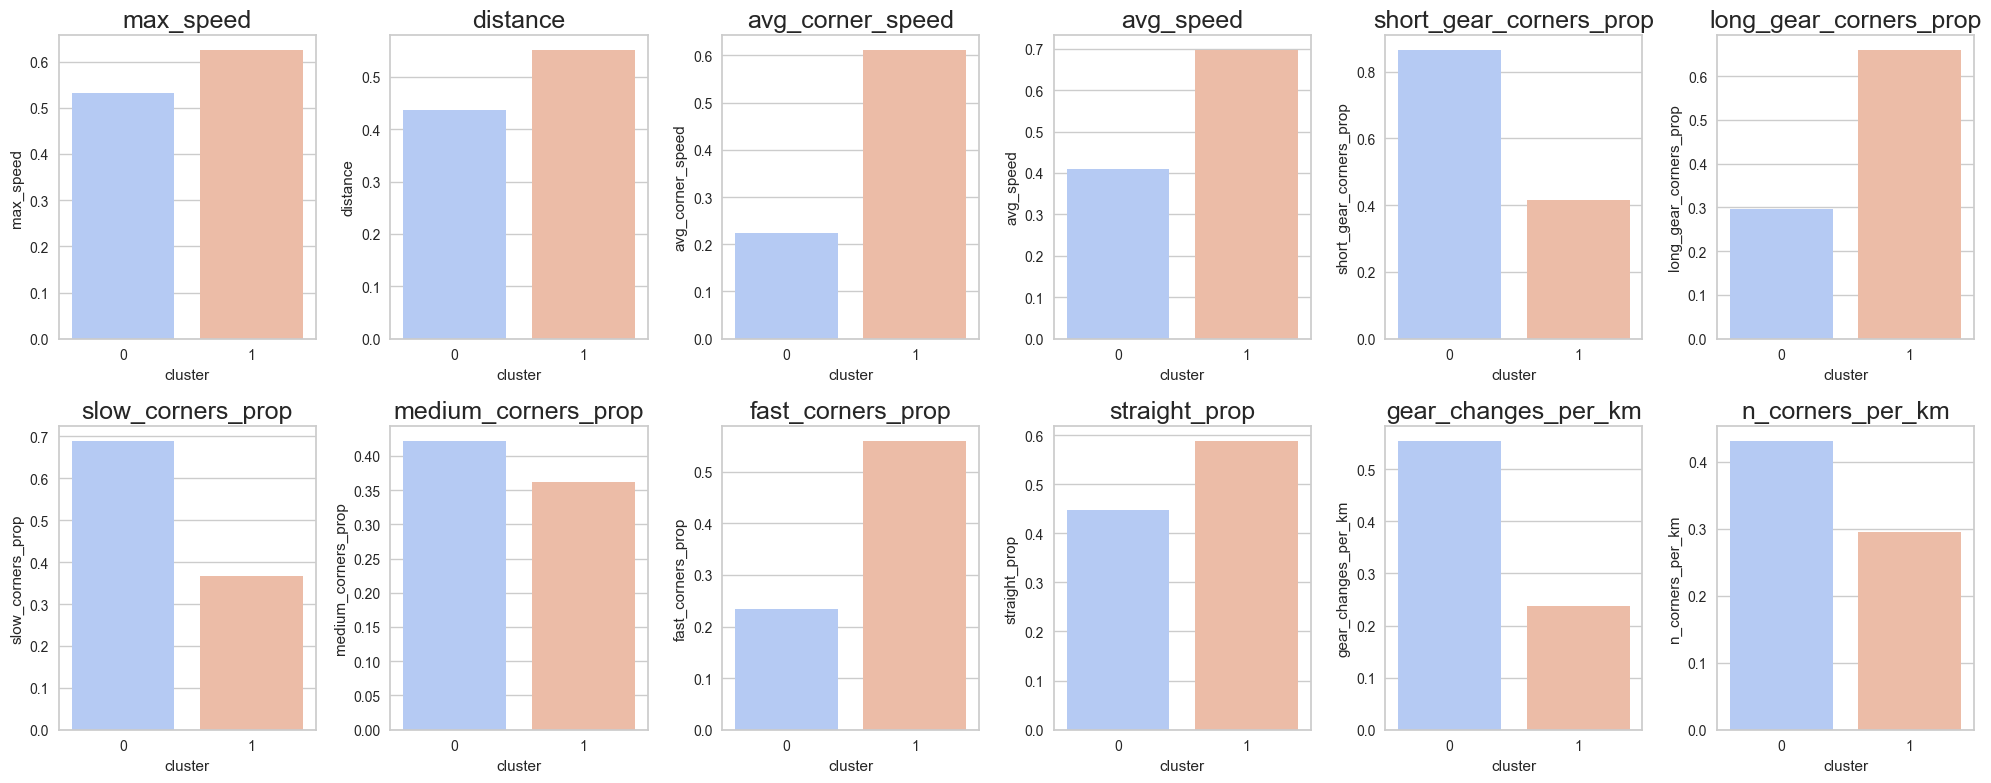

In [28]:
plot_clusters(df_kmeans_result)

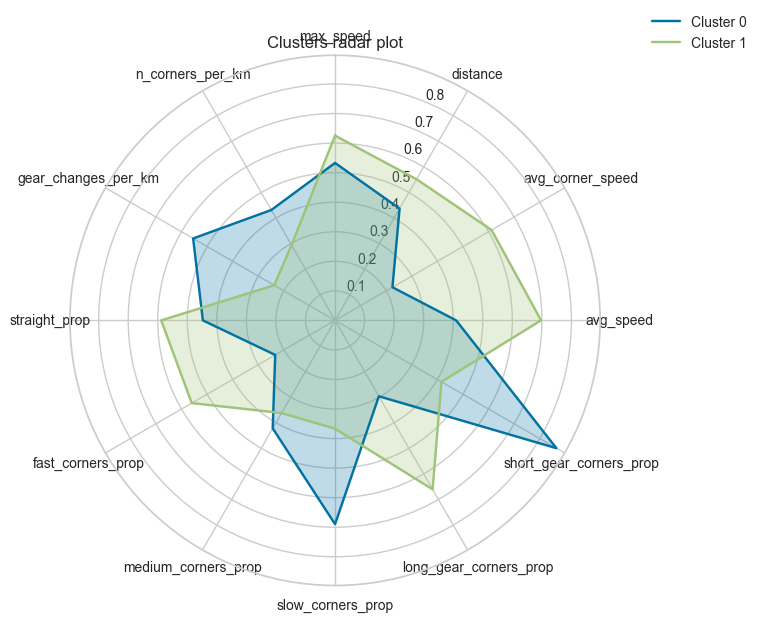

In [29]:
variables = df_kmeans_result.drop(columns='cluster').columns

plot_radar(df_kmeans_result, variables)

In [132]:
# plot_relation_tv(df_kmeans_result, 'cluster', size=(20, 10), n_cols = 2)

In [212]:
X = df_kmeans_result.drop(columns='cluster').values

In [213]:
from sklearn.metrics import silhouette_samples, silhouette_score

# The silhouette_score for data set is used for measuring the mean of the Silhouette Coefficient for each sample belonging to different clusters.

score = silhouette_score(X, df_kmeans_result['cluster'], metric='euclidean')

y_pred = model_kmeans.predict(X)

In [214]:
cols = df_kmeans_result.drop(columns='cluster').columns

cols

Index(['laptime', 'max_speed', 'distance', 'n_corners', 'avg_corner_speed',
       'avg_speed', 'throttle_perc', 'brake_perc', 'straight_lenght',
       'gear_changes', 'n_slow_corners', 'n_medium_corners', 'n_fast_corners',
       'n_gear1_corners', 'n_gear2_corners', 'n_gear3_corners',
       'n_gear4_corners', 'n_gear5_corners', 'n_gear6_corners',
       'n_gear7_corners', 'n_gear8_corners'],
      dtype='object')

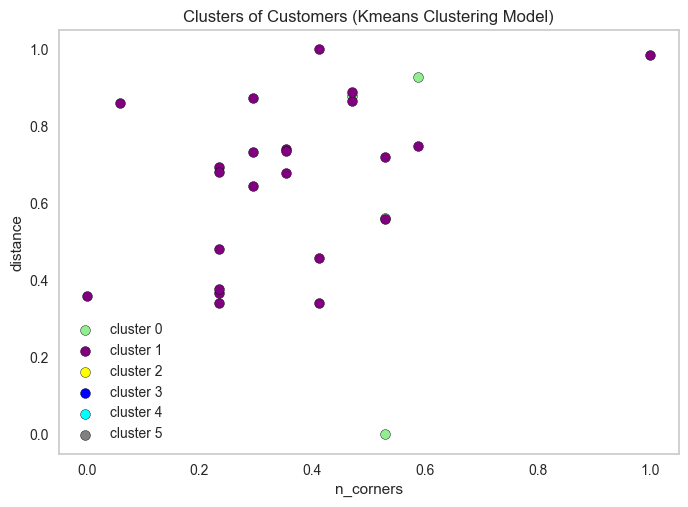

In [215]:
x_ax = 3
y_ax = 2

plt.scatter(X[y_pred==0,x_ax],X[y_pred==0,y_ax],s=50, c='lightgreen',edgecolor='black',  label='cluster 0')
plt.scatter(X[y_pred==1,x_ax],X[y_pred==1,y_ax],s=50, c='purple',edgecolor='black', label='cluster 1')
plt.scatter(X[y_pred==2,x_ax],X[y_pred==2,y_ax],s=50, c='yellow',edgecolor='black', label='cluster 2')
plt.scatter(X[y_pred==3,x_ax],X[y_pred==3,y_ax],s=50, c='blue',edgecolor='black', label='cluster 3')
plt.scatter(X[y_pred==4,x_ax],X[y_pred==4,y_ax],s=50, c='cyan',edgecolor='black',  label='cluster 4')
plt.scatter(X[y_pred==5,x_ax],X[y_pred==5,y_ax],s=50, c='grey',edgecolor='black',  label='cluster 5')
# plt.scatter(model_kmeans.cluster_centers_[:,0],model_kmeans.cluster_centers_[:,1],s=100,c='red', label='centroids')
plt.title('Clusters of Customers (Kmeans Clustering Model)')
plt.xlabel(cols[x_ax])
plt.ylabel(cols[y_ax])
plt.legend()
plt.grid()
plt.show()

In [216]:
df_kmeans_result.sort_values(by='cluster')['cluster']

sochi             0
marina_bay        0
baku              0
monaco            0
hockenheimring    1
vegas             1
rodriguez         1
americas          1
monza             1
zandvoort         1
hungaroring       1
silverstone       1
red_bull_ring     1
catalunya         1
villeneuve        1
imola             1
miami             1
shanghai          1
suzuka            1
albert_park       1
jeddah            1
bahrain           1
ricard            1
istanbul          1
nurburgring       1
losail            1
yas_marina        1
Name: cluster, dtype: int32

For n_clusters = 2 The average silhouette_score is : 0.27269007910520454
For n_clusters = 3 The average silhouette_score is : 0.26775259477780944
For n_clusters = 4 The average silhouette_score is : 0.1853446447500558
For n_clusters = 5 The average silhouette_score is : 0.21417262039391763
For n_clusters = 6 The average silhouette_score is : 0.2219124540228273


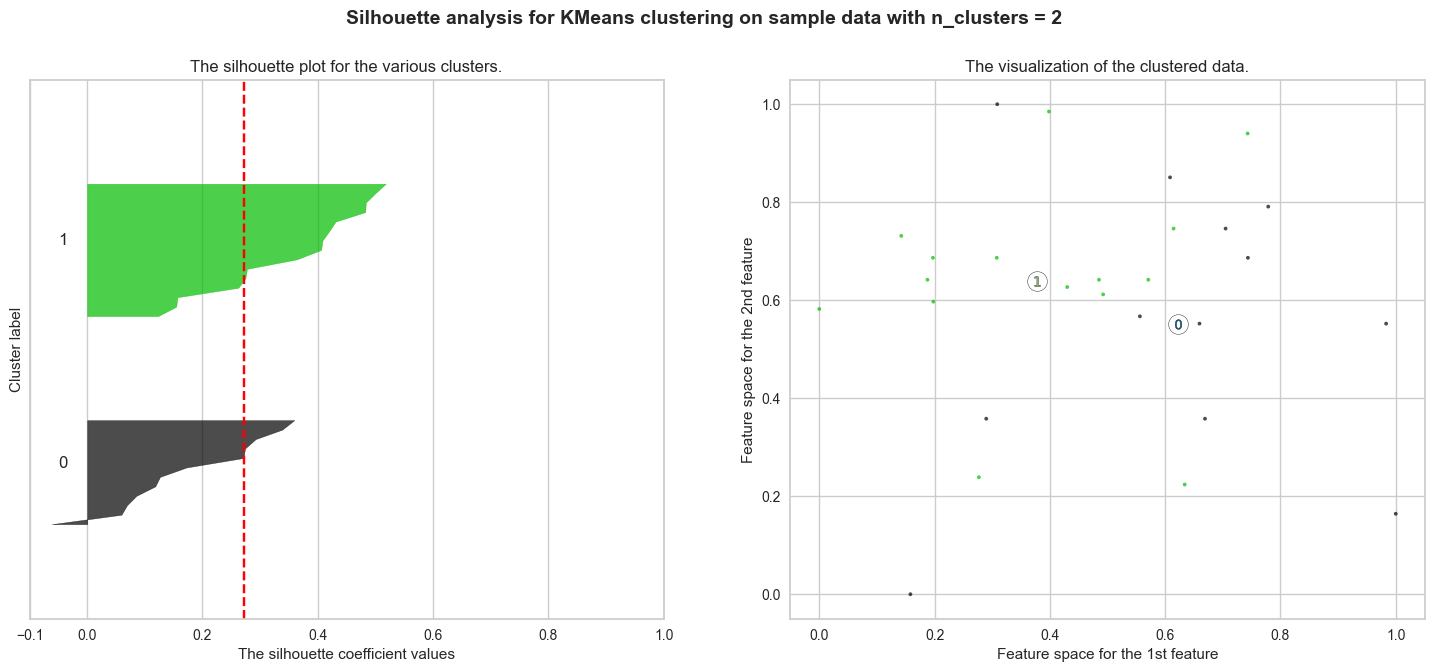

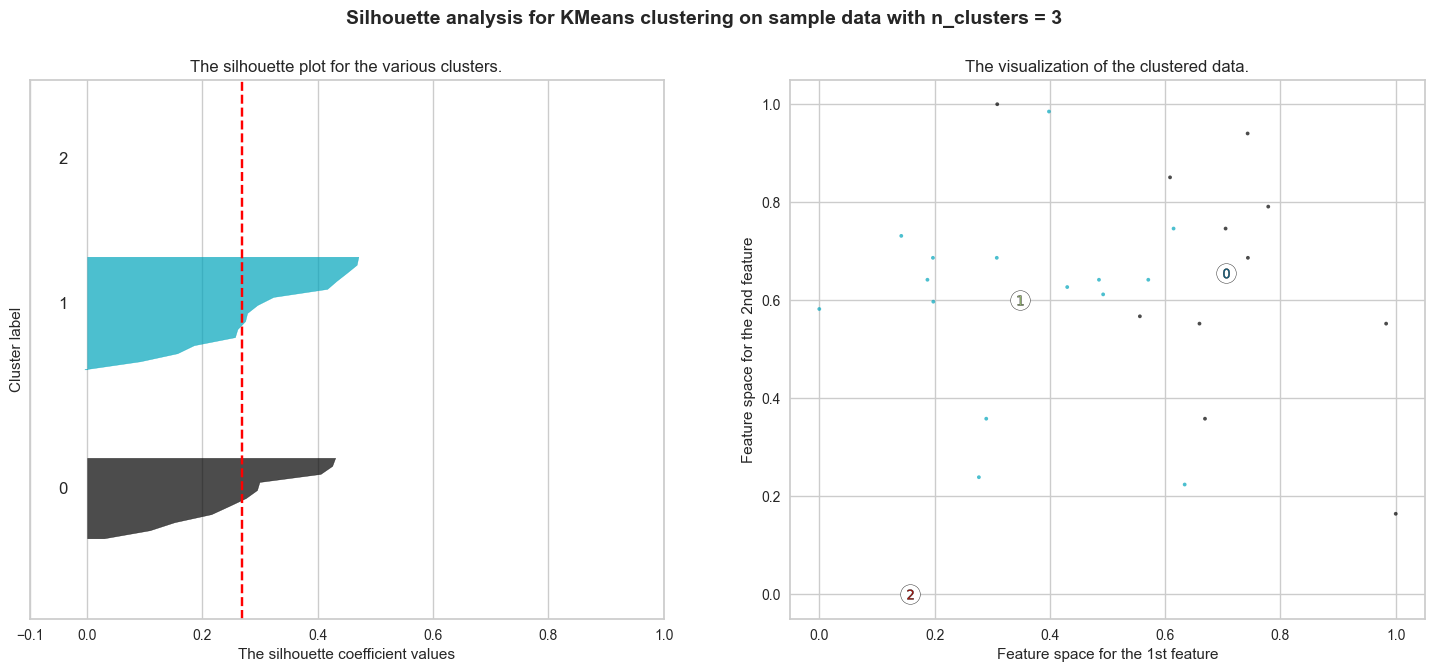

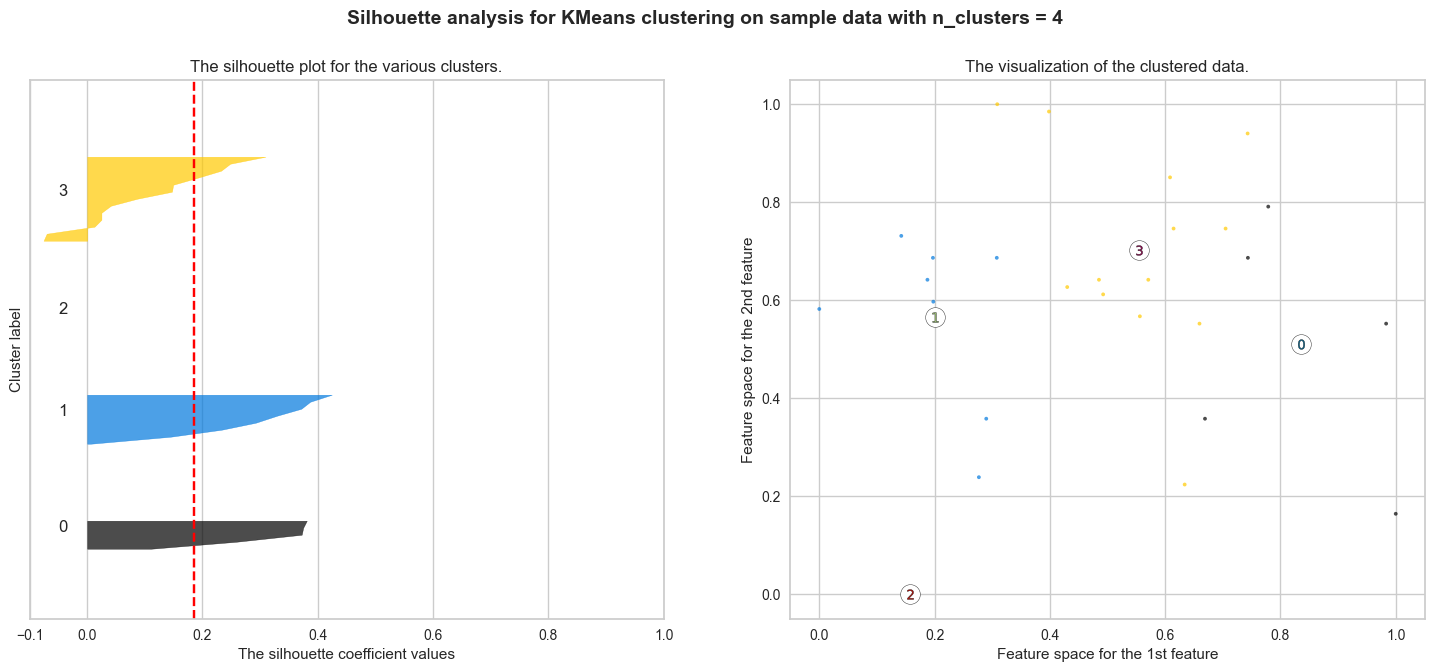

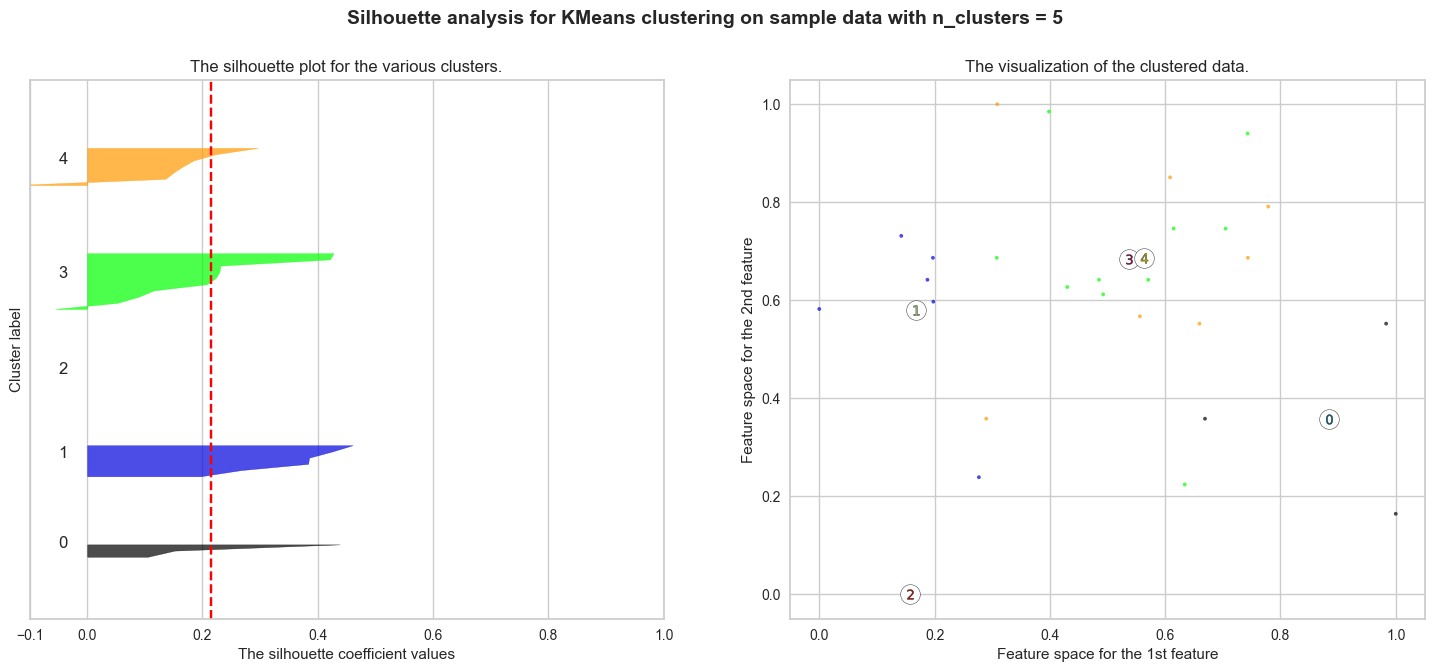

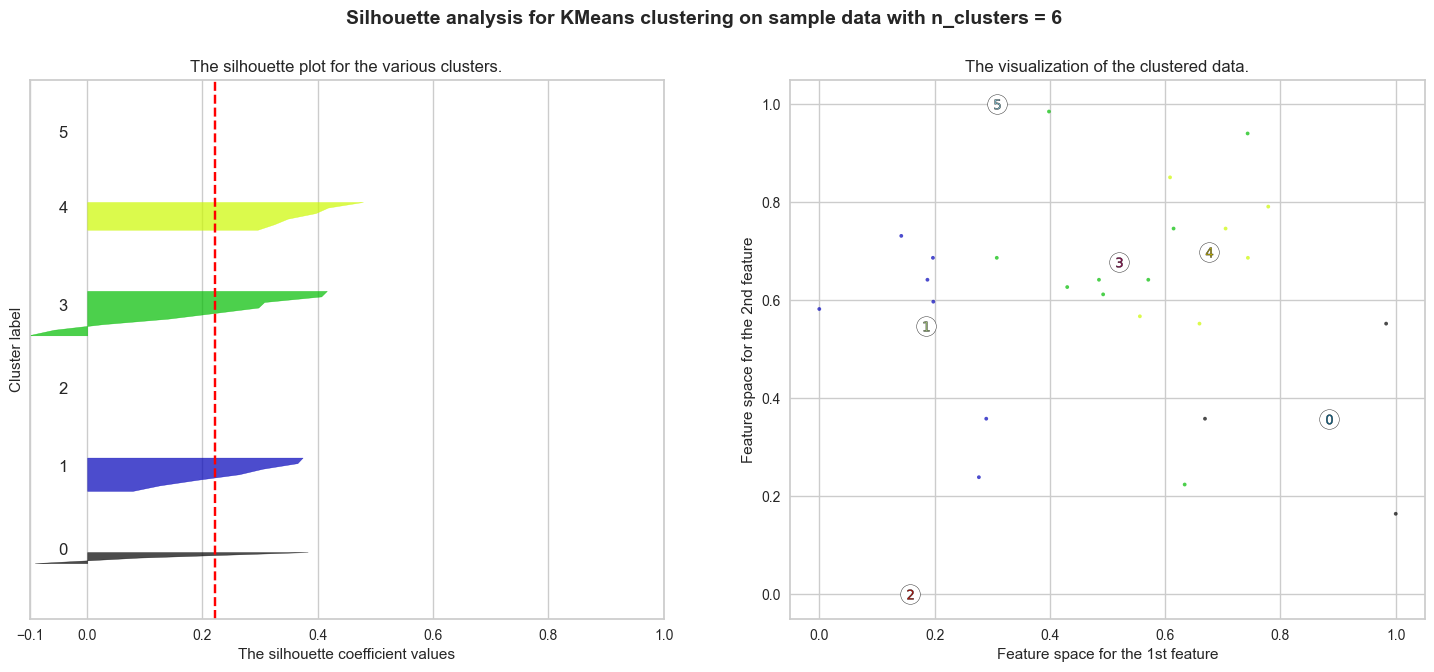

In [177]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

---

### Modelo de PCA (reducción de la dimensionalidad)

In [217]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca = pca.fit_transform(df_scaled)

pca_df = pd.DataFrame(data=pca, columns=['Col1', 'Col2'])

pca_clusters = pd.concat([pca_df, df_kmeans_result['cluster'].reset_index()], axis=1)

<Axes: xlabel='Col1', ylabel='Col2'>

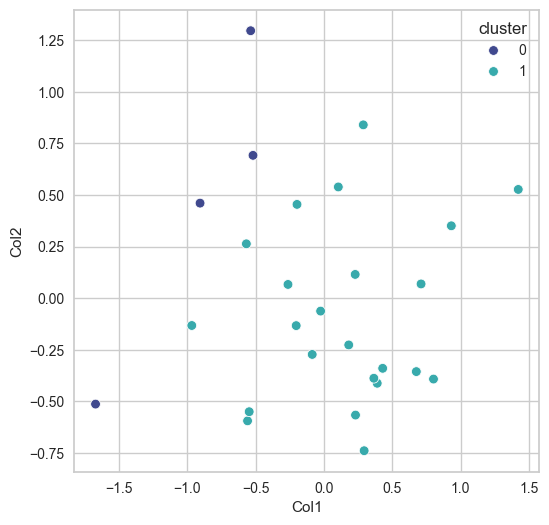

In [218]:
fig = plt.figure(figsize=(6,6))

sns.scatterplot(data=pca_clusters, x='Col1', y='Col2', hue='cluster', palette='mako')

---

## 4.2 Agglomerative clustering

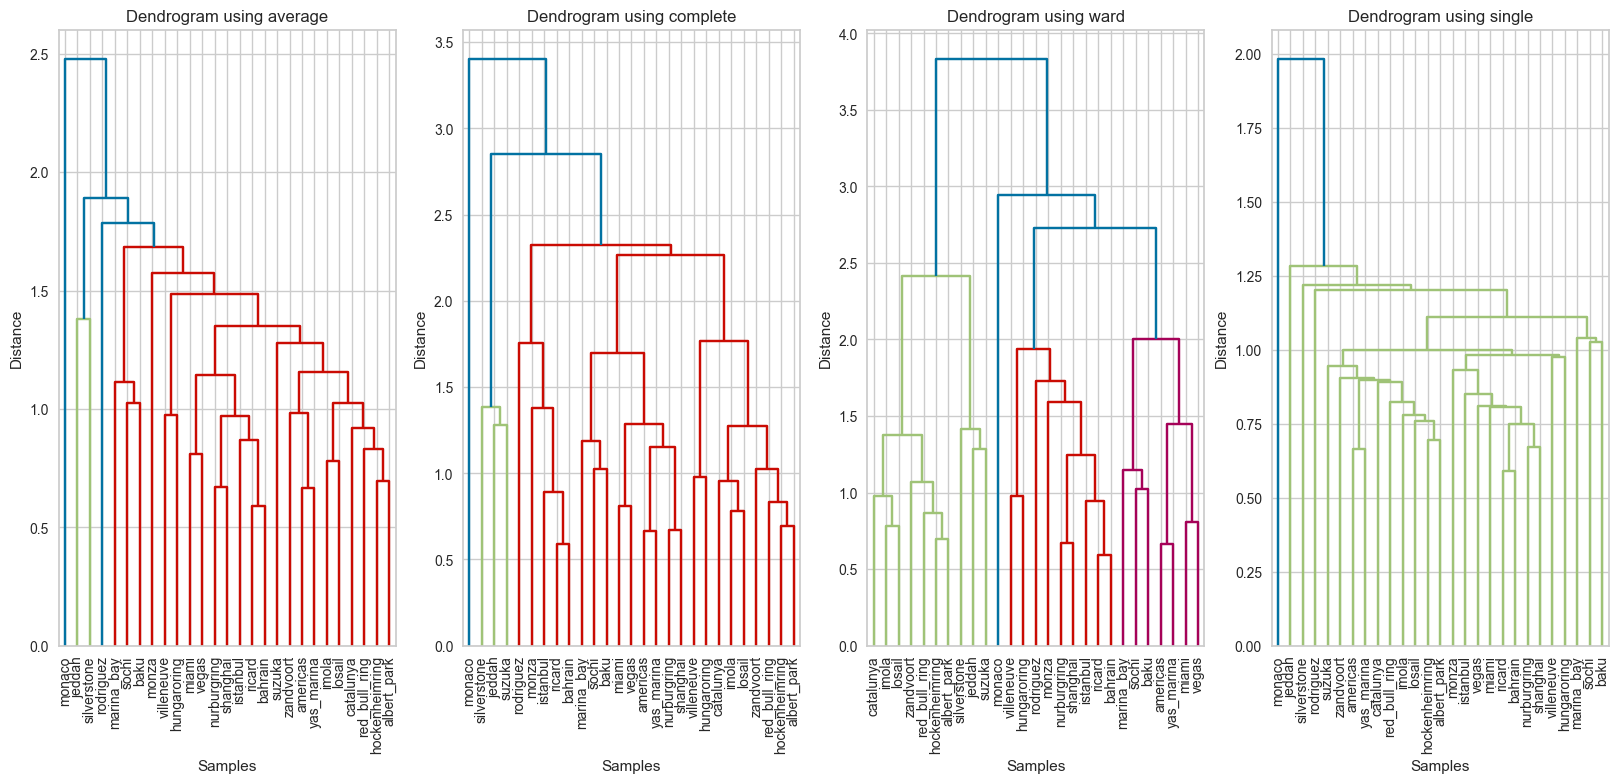

In [219]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)